<a href="https://colab.research.google.com/github/EGR02/Goldman-Sachs-stock-prediction-seven-days-trend/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM 1 dense with two features. One-Day ahead predictions.
Last run 05/05/2021. Some results results might change when compared with what we wrote on the report (written on the 05/04/2021)

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 9.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=b1b76a294d60748674958a74e0433ce670de48b20072238b0b7a66c6853adf02
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L1L2
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [ ]:
GS = yf.download('GS', 
                      start='2000-01-01', 
                      end= datetime.now(), 
                      progress=False)

all_data = GS[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
#all_data.tail(5)
all_data.info()
print(all_data.tail)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5369 entries, 2000-01-03 to 2021-05-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5369 non-null   float64
 1   Open       5369 non-null   float64
 2   High       5369 non-null   float64
 3   Low        5369 non-null   float64
 4   Close      5369 non-null   float64
 5   Volume     5369 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 293.6 KB
<bound method NDFrame.tail of             Adj Close    Open    High     Low   Close   Volume
Date                                                          
2000-01-03      68.83   94.19   94.38   87.75   88.31  1822600
2000-01-04      64.49   87.00   87.50   82.25   82.75  1647700
2000-01-05      61.47   80.88   81.88   78.38   78.88  1516600
2000-01-06      64.10   78.62   84.50   78.62   82.25  1845100
2000-01-07      64.35   83.06   83.19   79.88   82.56  1127400
...               ...     ...    

In [ ]:
#We downloaded the data in order to see what are the significant features/variables for our project
#all_data.to_csv("GS.csv")

#https://towardsdatascience.com/the-2-step-guide-to-upload-images-in-google-colab-b51348e882e4#:~:text=Step%20I%3A%20Upload%20the%20image,a%20sharable%20link%20%26%20copy%20it.&text=Open%20Google%20Colab%20Notebook%20%26%20add,want%20to%20include%20the%20image.
#loading feature engineering images

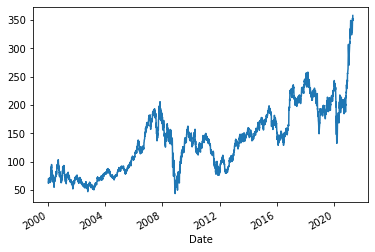

In [ ]:
#Target: adj. close. Other significant variable: Volume.
plot1 = plt.figure(1)
all_data['Adj Close'].plot()

#plot2 = plt.figure(2)
#all_data['Volume'].plot()
plt.show()

In [ ]:
all_data = all_data[:].astype('float32')
all_data.dtypes

Adj Close    float32
Open         float32
High         float32
Low          float32
Close        float32
Volume       float32
dtype: object

In [ ]:
DataSet = all_data[['Adj Close', 'Volume']]

<Figure size 432x288 with 0 Axes>

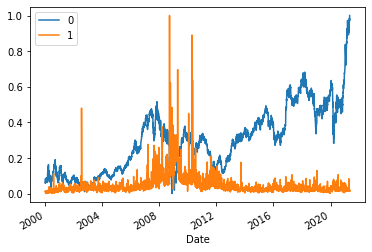

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
DataSet_set_scaled = min_max_scaler.fit_transform(all_data[['Adj Close', 'Volume']])
GS_scaled = pd.DataFrame(min_max_scaler.fit_transform(DataSet_set_scaled).squeeze(), index = GS.index)
plot1 = plt.figure(1)
GS_scaled.plot()
plt.show()

In [ ]:
#def create_univariate_rnn_data(data, window_size):
window_size = 5
y = GS_scaled[window_size:][0]
data = GS_scaled.values.reshape(-1,1,2)
n = data.shape[0]

x = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
print(x)



[[[0.08066724 0.01248319]
  [0.06685129 0.01095158]
  [0.05723745 0.00980353]
  [0.06560977 0.01268022]
  [0.06640562 0.00639528]]

 [[0.06685129 0.01095158]
  [0.05723745 0.00980353]
  [0.06560977 0.01268022]
  [0.06640562 0.00639528]
  [0.07089421 0.00355537]]

 [[0.05723745 0.00980353]
  [0.06560977 0.01268022]
  [0.06640562 0.00639528]
  [0.07089421 0.00355537]
  [0.07197656 0.00360353]]

 ...

 [[0.9551141  0.01553852]
  [0.96501446 0.01481256]
  [0.96972585 0.01527056]
  [0.9851972  0.01915431]
  [0.97080827 0.01491765]]

 [[0.96501446 0.01481256]
  [0.96972585 0.01527056]
  [0.9851972  0.01915431]
  [0.97080827 0.01491765]
  [0.97625184 0.01291316]]

 [[0.96972585 0.01527056]
  [0.9851972  0.01915431]
  [0.97080827 0.01491765]
  [0.97625184 0.01291316]
  [0.9752332  0.02130942]]]


In [ ]:

#x, y = create_univariate_rnn_data(GS_scaled, window_size)
#pd.Series(DataSet.squeeze() --> normal price
prova = np.array(all_data["Adj Close"]).reshape(-1,1)
scalar2 = preprocessing.MinMaxScaler()
scalar2.fit_transform(prova)

array([[0.08066724],
       [0.06685129],
       [0.05723745],
       ...,
       [0.97625184],
       [0.9752332 ],
       [1.        ]], dtype=float32)

In [ ]:
x_train = all_data[:'2020-06-30']
x_valid = all_data['2020-07-01':'2021-03-31']
x_test = all_data['2021-04-01':]

x_l_train = len(x_train) 
x_l_valid = len(x_valid)
x_l_test = len(x_test)

# These represent the upper limit
L_Y_train = len(all_data) -len(x_valid) - len(x_test) 
L_Y_valid = len(all_data) - len(x_test)
#X and Y train
x_train = x[:L_Y_train - window_size]
y_train = y[:L_Y_train - window_size]


# X and Y Valid 
x_valid = x[L_Y_train - window_size:L_Y_valid-window_size]
y_valid = y[L_Y_train - window_size:L_Y_valid-window_size]

#print(x_valid.shape, y_valid.shape, x_l_valid)

# X test
x_test = x[L_Y_valid-window_size:]
y_test = y[L_Y_valid-window_size:]
#print(x_test.shape, y_test.shape, x_l_test)









In [ ]:
results_path = Path('results', 'time_series')
lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [ ]:
# The architecture 
model = Sequential()
model.add(LSTM(units= 50, return_sequences = True, input_shape=(x_train.shape[1],2), activation='relu'))
model.add(LSTM(units= 50, activation='relu'))
model.add(Dense(units=1))

# Compiling (Changing optimizer to adam?)
model.compile(optimizer= 'adam',loss='mean_squared_error')

# fitting to the training set
history = model.fit(x_train,y_train,epochs=150,batch_size=150, verbose=0, validation_data = (x_valid, y_valid),callbacks= [early_stopping, checkpointer])


Epoch 00001: val_loss improved from inf to 0.01962, saving model to results/time_series/lstm.h5

Epoch 00002: val_loss improved from 0.01962 to 0.00315, saving model to results/time_series/lstm.h5

Epoch 00003: val_loss did not improve from 0.00315

Epoch 00004: val_loss did not improve from 0.00315

Epoch 00005: val_loss improved from 0.00315 to 0.00237, saving model to results/time_series/lstm.h5

Epoch 00006: val_loss improved from 0.00237 to 0.00191, saving model to results/time_series/lstm.h5

Epoch 00007: val_loss did not improve from 0.00191

Epoch 00008: val_loss improved from 0.00191 to 0.00169, saving model to results/time_series/lstm.h5

Epoch 00009: val_loss improved from 0.00169 to 0.00168, saving model to results/time_series/lstm.h5

Epoch 00010: val_loss improved from 0.00168 to 0.00156, saving model to results/time_series/lstm.h5

Epoch 00011: val_loss did not improve from 0.00156

Epoch 00012: val_loss did not improve from 0.00156

Epoch 00013: val_loss improved from 

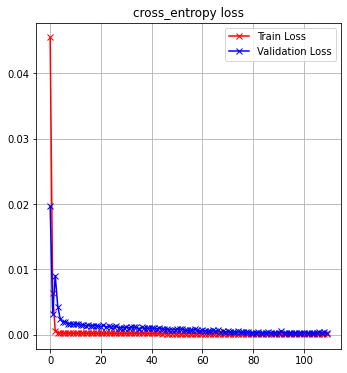

In [ ]:
#print(history.history.keys())
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    

plot_loss_accuracy(history)

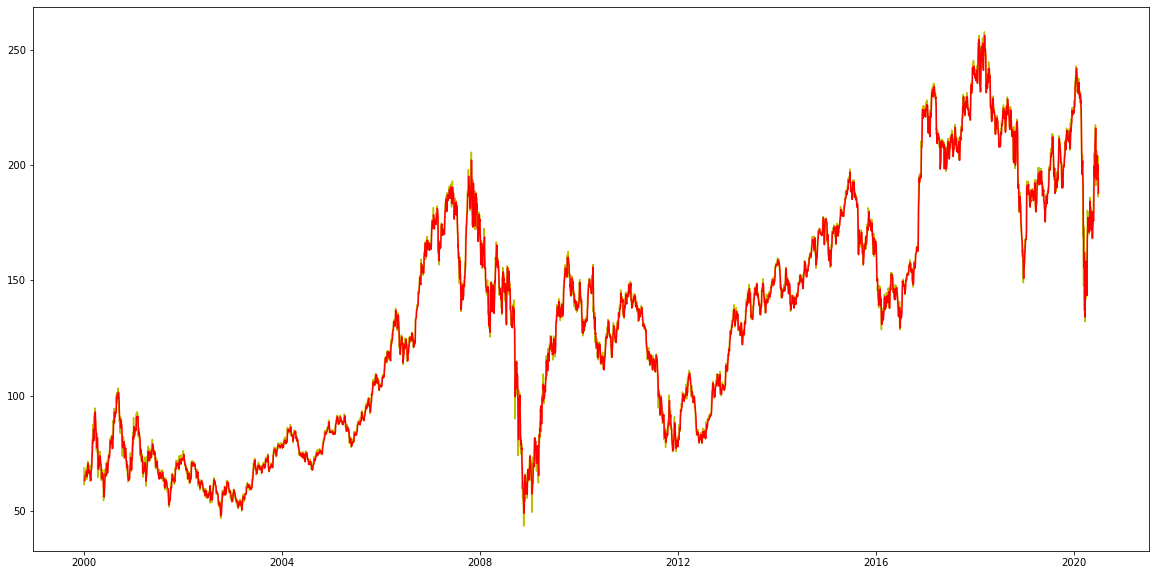

In [ ]:
#Train predictions
train_preds = model.predict(x_train)
train_preds = scalar2.inverse_transform(train_preds)
PredsTrainFrame = pd.DataFrame(train_preds, index = all_data.index[window_size:L_Y_train])
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(all_data[:'2020-06-30']["Adj Close"], 'y')
ax.plot(PredsTrainFrame, 'r')
plt.show()

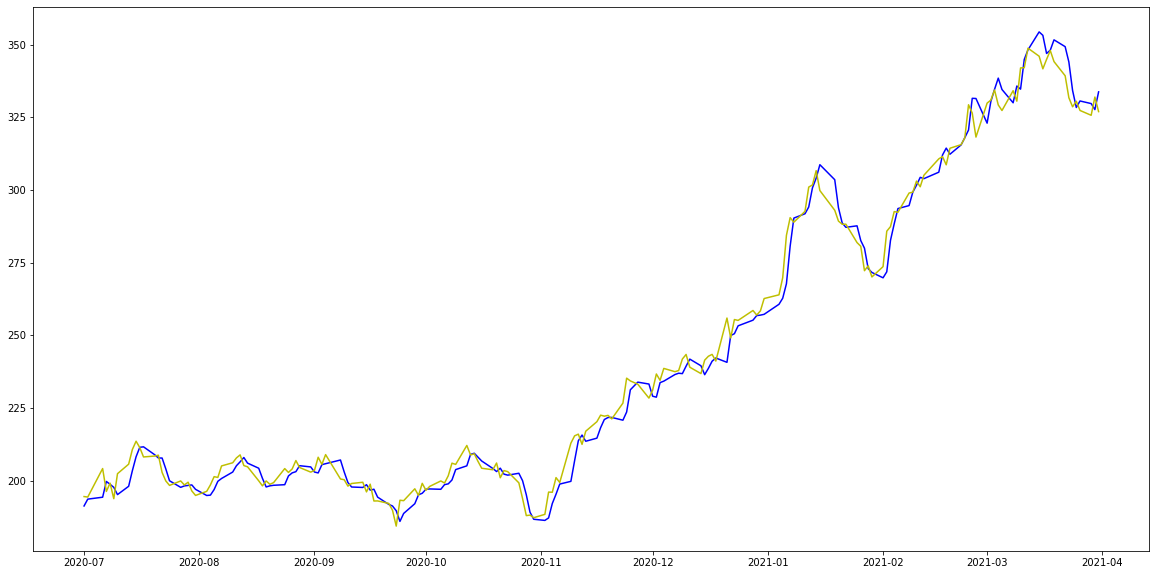

In [ ]:
#Valid preditions
valid_preds = model.predict(x_valid)
valid_preds = scalar2.inverse_transform(valid_preds)
PredsValidFrame = pd.DataFrame(valid_preds, index = all_data.index[L_Y_train:L_Y_valid])

plt.close()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(PredsValidFrame, 'b')
ax.plot(all_data['2020-07-01': '2021-03-31']["Adj Close"], 'y')
plt.show()

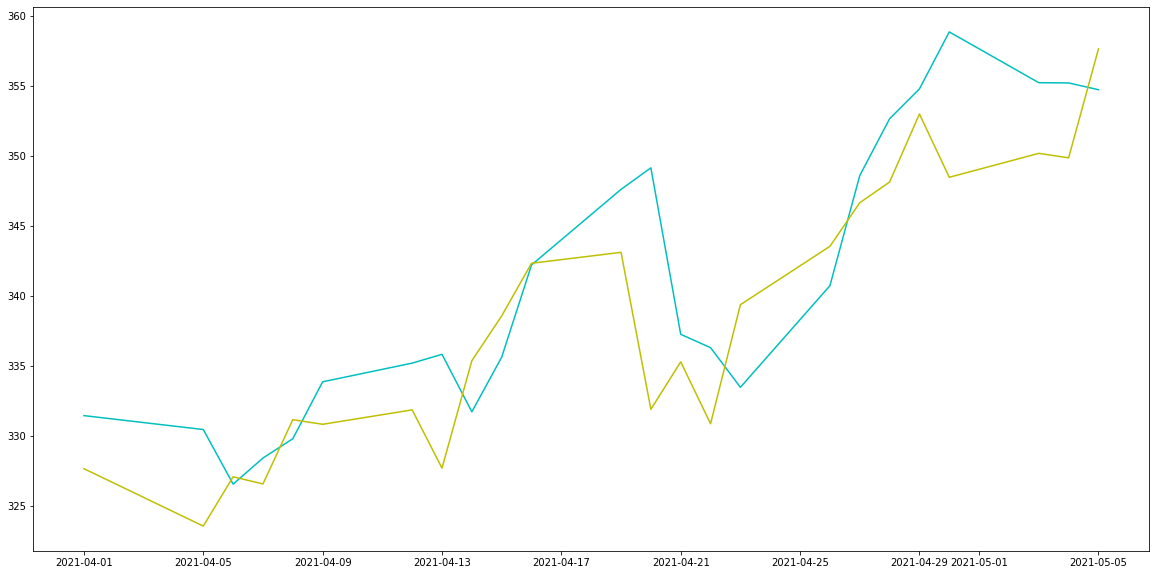

In [ ]:
# Test predictions
test_preds = model.predict(x_test)
test_preds = scalar2.inverse_transform(test_preds)

PredsTestFrame = pd.DataFrame(test_preds, index = all_data.index[L_Y_valid:])
plt.close()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(PredsTestFrame, 'c')
ax.plot(all_data['2021-04-01':]["Adj Close"], 'y')
plt.show()

In [ ]:

y_train_rescaled = scalar2.inverse_transform(np.array(y_train).reshape(-1,1))

train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, train_preds))# Train Standard Deviation

y_valid_rescaled = scalar2.inverse_transform(np.array(y_valid).reshape(-1,1))

valid_rmse = np.sqrt(mean_squared_error(y_valid_rescaled,valid_preds))# Valid Standard Deviation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


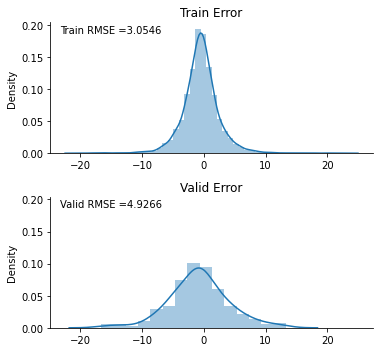

In [ ]:
fig=plt.figure(figsize=(10,5))


#with sns.axes_style("white"):
ax2 = plt.subplot(222)
ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
sns.distplot(train_preds - y_train_rescaled, ax=ax2)
ax2.set_title('Train Error')
ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
sns.distplot(valid_preds - y_valid_rescaled, ax=ax4)
ax4.set_title('Valid Error')
ax4.text(x=.03, y=.92, s=f'Valid RMSE ={valid_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()

LSTM 1 dense with one single feature (Adj. close) (Univariate model). Base case for our a week-ahead model.
Some code lines are repeated. We did not have time to present all three mdoels in a nicer way.

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L1L2
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [ ]:
GS = yf.download('GS', 
                      start='2000-01-01', 
                      end= datetime.now(), 
                      progress=False)

all_data = GS[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
#all_data.tail(5)
all_data.info()
print(all_data.tail)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5369 entries, 2000-01-03 to 2021-05-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5369 non-null   float64
 1   Open       5369 non-null   float64
 2   High       5369 non-null   float64
 3   Low        5369 non-null   float64
 4   Close      5369 non-null   float64
 5   Volume     5369 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 293.6 KB
<bound method NDFrame.tail of             Adj Close    Open    High     Low   Close   Volume
Date                                                          
2000-01-03      68.83   94.19   94.38   87.75   88.31  1822600
2000-01-04      64.49   87.00   87.50   82.25   82.75  1647700
2000-01-05      61.47   80.88   81.88   78.38   78.88  1516600
2000-01-06      64.10   78.62   84.50   78.62   82.25  1845100
2000-01-07      64.35   83.06   83.19   79.88   82.56  1127400
...               ...     ...    

In [ ]:
all_data = all_data[:].astype('float32')
all_data.dtypes
DataSet = all_data['Adj Close']

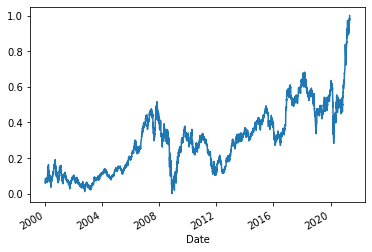

In [ ]:
DataSet = np.array(DataSet)
scaler = MinMaxScaler()
DataSet = DataSet.reshape(-1,1)
GS_scaled = pd.Series(scaler.fit_transform(DataSet).squeeze(), index = GS.index)
plot1 = plt.figure(1)
GS_scaled.plot()
plt.show()

In [ ]:
# These re_normalization was done for rescaling the price subsequntly when we have to plot our results
prova = np.array(all_data["Adj Close"]).reshape(-1,1)
scalar2 = preprocessing.MinMaxScaler()
scalar2.fit_transform(prova)

array([[0.08066724],
       [0.06685129],
       [0.05723745],
       ...,
       [0.97625184],
       [0.9752332 ],
       [1.        ]], dtype=float32)

In [ ]:
#machine l. book
def create_univariate_rnn_data(data, window_size):
  y = data[window_size:]
  data = data.values.reshape(-1, 1)
  n = data.shape[0]
  x = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))

  return pd.DataFrame(x, index = y.index), y

In [ ]:
window_size=63
x, y = create_univariate_rnn_data(GS_scaled, window_size)
#pd.Series(DataSet.squeeze() --> normal price
print(x,y)

                  0         1         2   ...        60        61        62
Date                                      ...                              
2000-04-03  0.080667  0.066851  0.057237  ...  0.145258  0.127081  0.123038
2000-04-04  0.066851  0.057237  0.065610  ...  0.127081  0.123038  0.123675
2000-04-05  0.057237  0.065610  0.066406  ...  0.123038  0.123675  0.105657
2000-04-06  0.065610  0.066406  0.070894  ...  0.123675  0.105657  0.103620
2000-04-07  0.066406  0.070894  0.071977  ...  0.105657  0.103620  0.124916
...              ...       ...       ...  ...       ...       ...       ...
2021-04-29  0.733613  0.721421  0.732722  ...  0.955114  0.965014  0.969726
2021-04-30  0.721421  0.732722  0.771528  ...  0.965014  0.969726  0.985197
2021-05-03  0.732722  0.771528  0.776526  ...  0.969726  0.985197  0.970808
2021-05-04  0.771528  0.776526  0.793016  ...  0.985197  0.970808  0.976252
2021-05-05  0.776526  0.793016  0.792220  ...  0.970808  0.976252  0.975233

[5306 rows 

In [ ]:
x_train = x[:'2020-06-30'].values.reshape(-1, x.shape[1], 1)
y_train = y[:'2020-06-30']
print(x_train.shape,y_train.shape)




#validation set
x_valid = x['2020-07-01':'2021-03-31'].values.reshape(-1, x.shape[1],1)
y_valid = y['2020-07-01':'2021-03-31']

# April 2021 for testing
x_test = x['2021-04-01':].values.reshape(-1, x.shape[1],1)
y_test = y['2021-04-01':]
print(x_test.shape, y_test.shape)

(5093, 63, 1) (5093,)
(24, 63, 1) (24,)


In [ ]:
results_path = Path('results', 'time_series')
lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [ ]:
model = Sequential()
model.add(LSTM(units= 50, return_sequences = True, input_shape=(x_train.shape[1],1), activation='relu'))
model.add(LSTM(units= 50, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Compiling
model.compile(optimizer= 'adam',loss='mean_squared_error')

In [ ]:
# Fitting to the training set
history = model.fit(x_train,y_train,epochs=150,batch_size=150, verbose=0, validation_data=(x_valid,y_valid) ,callbacks= [early_stopping, checkpointer])


Epoch 00001: val_loss improved from inf to 0.01129, saving model to results/time_series/lstm.h5

Epoch 00002: val_loss improved from 0.01129 to 0.00277, saving model to results/time_series/lstm.h5

Epoch 00003: val_loss improved from 0.00277 to 0.00242, saving model to results/time_series/lstm.h5

Epoch 00004: val_loss improved from 0.00242 to 0.00186, saving model to results/time_series/lstm.h5

Epoch 00005: val_loss improved from 0.00186 to 0.00162, saving model to results/time_series/lstm.h5

Epoch 00006: val_loss improved from 0.00162 to 0.00140, saving model to results/time_series/lstm.h5

Epoch 00007: val_loss did not improve from 0.00140

Epoch 00008: val_loss improved from 0.00140 to 0.00125, saving model to results/time_series/lstm.h5

Epoch 00009: val_loss improved from 0.00125 to 0.00118, saving model to results/time_series/lstm.h5

Epoch 00010: val_loss did not improve from 0.00118

Epoch 00011: val_loss did not improve from 0.00118

Epoch 00012: val_loss improved from 0.0

In [ ]:
#prediction = model.predict(x_test[-1].reshape(1,63,1))
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
#print(x_test[-1].reshape(1,63,1))
#print(prediction)

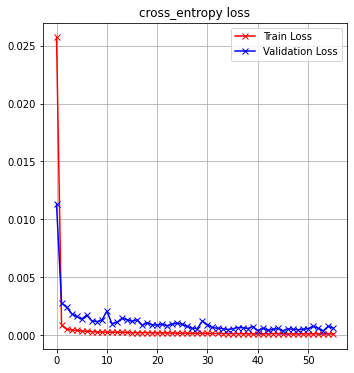

In [ ]:
#print(history.history.keys())
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    

plot_loss_accuracy(history)
#print(history.history.keys())

In [ ]:
######################
def future(batch):
  last_prediction = model.predict(batch.reshape(1,63,1))
  new_batch = np.delete(batch, 0)
  new_batch = np.append(new_batch, last_prediction)
  last_prediction = scaler.inverse_transform(last_prediction)

  return new_batch, last_prediction

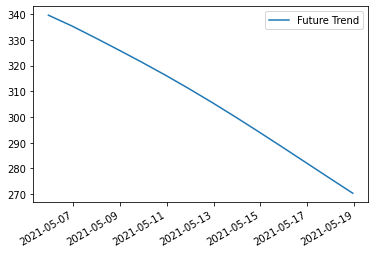

2021-05-05 22:38:58.170037    339.571350
2021-05-06 22:38:58.170084    335.396210
2021-05-07 22:38:58.170089    330.788879
2021-05-08 22:38:58.170091    326.057983
2021-05-09 22:38:58.170093    321.233215
2021-05-10 22:38:58.170095    316.229218
2021-05-11 22:38:58.170097    311.005402
2021-05-12 22:38:58.170098    305.561676
2021-05-13 22:38:58.170100    299.920929
2021-05-14 22:38:58.170102    294.120392
2021-05-15 22:38:58.170103    288.206390
2021-05-16 22:38:58.170105    282.230682
2021-05-17 22:38:58.170107    276.246033
2021-05-18 22:38:58.170109    270.311188
Name: Future Trend, dtype: float32


In [ ]:
######################
last_batch = x_test[-1]
i = 0
future_trend = []
while i < 14:
  new_batch, last_prediction = future(last_batch)
  future_trend.append(last_prediction)
  last_batch = new_batch
  i += 1

future_trend = np.array(future_trend)
#future_trend = future_trend.reshape(future_trend.shape[0],1)

future_trend = future_trend.reshape(-1)
dates = []
i = 0
while i <14:
  dates.append((datetime.now() + timedelta(days=i))) #.strftime('%Y-%m-%d')
  i += 1

#fut_trend = future_trend.reshape(-1,1)
future_trend = pd.DataFrame(columns =["Future Trend"],data = np.asarray(future_trend), index = dates)
future_trend.plot()
plt.show()
print(future_trend.loc['2021-04-21':]["Future Trend"])
# the dates include Sundays and Saturdays, just for making easier our job.

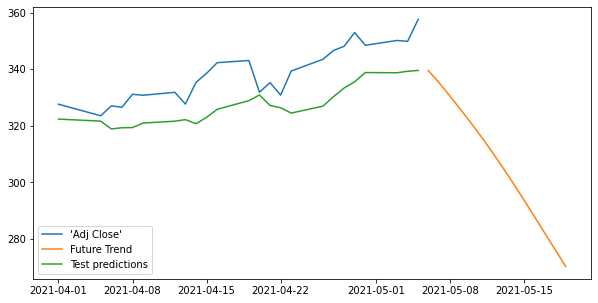

In [ ]:
######################
merge=pd.concat([all_data.loc['2021-04-01': ,'Adj Close'] , future_trend.loc['2021-04-21':,:]], axis = 1)
pred = pd.DataFrame(columns =["Predictions"],data = prediction, index = all_data.index[-len(prediction):])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(merge['Adj Close'], label = "'Adj Close'")
ax.plot(merge["Future Trend"], label = "Future Trend")
ax.plot(pred, label = "Test predictions")
plt.legend(loc = "lower left")

plt.show()

In [ ]:
train_predict = model.predict(x_train)
valid_predict = model.predict(x_valid)
test_predict = model.predict(x_test)

In [ ]:
y_train_rescaled = scalar2.inverse_transform(np.array(y_train).reshape(-1,1))
y_valid_rescaled = scalar2.inverse_transform(np.array(y_valid).reshape(-1,1))

In [ ]:
train_predict1 = pd.DataFrame(scaler.inverse_transform(train_predict).squeeze(), index = y[:'2020-06-30'].index)
valid_predict1 = pd.DataFrame(scaler.inverse_transform(valid_predict).squeeze(), index = y['2020-07-01':'2021-03-31'].index)
test_predict1 = pd.DataFrame(scaler.inverse_transform(test_predict).squeeze(), index = GS_scaled['2021-04-01':].index)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(train_predict1, y_train_rescaled))
valid_rmse = np.sqrt(mean_squared_error(valid_predict1, y_valid_rescaled))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


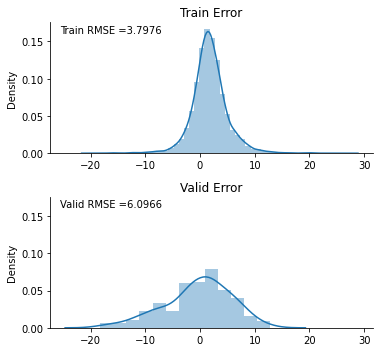

In [ ]:
fig=plt.figure(figsize=(10,5))
      
ax2 = plt.subplot(222)
ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
sns.distplot(train_predict1 - y_train_rescaled, ax=ax2)
ax2.set_title('Train Error')
ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
sns.distplot(valid_predict1 - y_valid_rescaled, ax=ax4)
ax4.set_title('Valid Error')
ax4.text(x=.03, y=.92, s=f'Valid RMSE ={valid_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()

plt.show()

Week- ahead model. LSTM 7 dense

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L1L2
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [ ]:
GS = yf.download('GS', 
                      start='2000-01-01', 
                      end= datetime.now(), 
                      progress=False)

all_data = GS[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
#all_data.tail(5)
all_data.info()
print(all_data.tail)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5369 entries, 2000-01-03 to 2021-05-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5369 non-null   float64
 1   Open       5369 non-null   float64
 2   High       5369 non-null   float64
 3   Low        5369 non-null   float64
 4   Close      5369 non-null   float64
 5   Volume     5369 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 293.6 KB
<bound method NDFrame.tail of             Adj Close    Open    High     Low   Close   Volume
Date                                                          
2000-01-03      68.83   94.19   94.38   87.75   88.31  1822600
2000-01-04      64.49   87.00   87.50   82.25   82.75  1647700
2000-01-05      61.47   80.88   81.88   78.38   78.88  1516600
2000-01-06      64.10   78.62   84.50   78.62   82.25  1845100
2000-01-07      64.35   83.06   83.19   79.88   82.56  1127400
...               ...     ...    

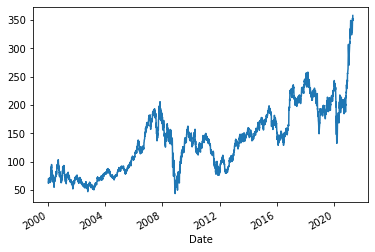

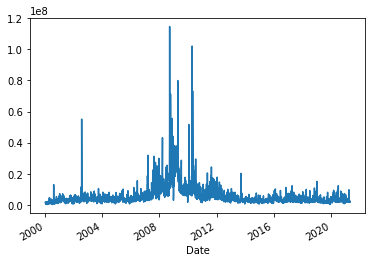

In [ ]:
plot1 = plt.figure(1)
all_data['Adj Close'].plot()

plot2 = plt.figure(2)
all_data['Volume'].plot()
plt.show()

In [ ]:
#all_data = all_data[:].astype('float32')
all_data.dtypes
DataSet = all_data['Adj Close']

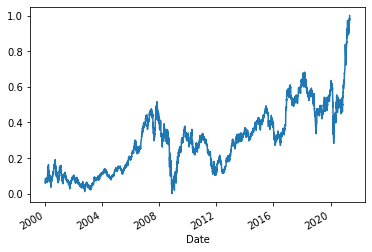

In [ ]:
DataSet = np.array(DataSet)
scaler = MinMaxScaler()
DataSet = DataSet.reshape(-1,1)
GS_scaled = pd.Series(scaler.fit_transform(DataSet).squeeze(), index = GS.index)
plot1 = plt.figure(1)
GS_scaled.plot()
plt.show()

In [ ]:
def create_univariate_rnn_data(data, window_size):
  y = data[window_size:]
  data = data.values.reshape(-1, 1)
  n = data.shape[0]
  x = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))

  return pd.DataFrame(x, index = y.index), y

In [ ]:
window_size = 63
x, y = create_univariate_rnn_data(GS_scaled, window_size)
#pd.Series(DataSet.squeeze() --> normal price
print(y)

Date
2000-04-03    0.123675
2000-04-04    0.105657
2000-04-05    0.103620
2000-04-06    0.124916
2000-04-07    0.116226
                ...   
2021-04-29    0.985197
2021-04-30    0.970808
2021-05-03    0.976252
2021-05-04    0.975233
2021-05-05    1.000000
Length: 5306, dtype: float64


In [ ]:
def targeting(data_y):
  y_ = []
  i = 0
  while i <= len(data_y) - 7:
    y_.append([data_y[i:i+7]])
    i += 1
  y = np.array(y_)
  return y.reshape(-1,7,1), pd.DataFrame(data = y.reshape(-1,7), index = data_y.index[:(len(data_y)-6)])

y_array, y_serie = targeting(y)
print(y_array)

[[[0.12367491]
  [0.10565689]
  [0.10361952]
  ...
  [0.11622577]
  [0.12755865]
  [0.12195588]]

 [[0.10565689]
  [0.10361952]
  [0.12491644]
  ...
  [0.12755865]
  [0.12195588]
  [0.10145481]]

 [[0.10361952]
  [0.12491644]
  [0.11622577]
  ...
  [0.12195588]
  [0.10145481]
  [0.09820775]]

 ...

 [[0.94183937]
  [0.95511412]
  [0.96501448]
  ...
  [0.98519721]
  [0.97080826]
  [0.97625187]]

 [[0.95511412]
  [0.96501448]
  [0.96972591]
  ...
  [0.97080826]
  [0.97625187]
  [0.97523318]]

 [[0.96501448]
  [0.96972591]
  [0.98519721]
  ...
  [0.97625187]
  [0.97523318]
  [1.        ]]]


In [ ]:
x_train = x[:'2020-06-30'].values.reshape(-1, x.shape[1], 1)
x_valid = x['2020-07-01':'2021-03-31'].values.reshape(-1, x.shape[1],1)
x_test = x['2021-04-01':].values.reshape(-1, x.shape[1],1)

# These represent the upper limit
L_Y_train = len(x) -len(x_valid) - len(x_test) 
L_Y_valid = len(x) - len(x_test) 



# Now, we create our target weeks
y_train = np.array(y_array[0:L_Y_train])
y_valid = np.array(y_array[L_Y_train:L_Y_valid])
#y_test = np.array(y_array[L_Y_valid:])
#we won't have a y_test because we want to use x_test to make real predictions each time the model is run, 
#so we do not have to delay the data by the window size as we did for the other models.




print(x_valid.shape, y_valid.shape)
#print(x_test.shape)

(189, 63, 1) (189, 7, 1)


In [ ]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:
lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience= 20,
                              restore_best_weights=True)

In [ ]:
model = Sequential()
model.add(LSTM(units= 60, return_sequences = True, input_shape=(x_train.shape[1],1), activation='relu'))
model.add(LSTM(units= 60, activation='relu'))
model.add(Dense(units=7))

In [ ]:
# Compiling
model.compile(optimizer= 'adam',loss='mean_squared_error')

In [ ]:
# Fitting to the training set
history = model.fit(x_train,y_train,epochs=150,batch_size=140, verbose=0, validation_data=(x_valid,y_valid) ,callbacks= [early_stopping, checkpointer])


Epoch 00001: val_loss improved from inf to 0.01735, saving model to results/univariate_time_series/lstm.h5

Epoch 00002: val_loss improved from 0.01735 to 0.01211, saving model to results/univariate_time_series/lstm.h5

Epoch 00003: val_loss improved from 0.01211 to 0.00465, saving model to results/univariate_time_series/lstm.h5

Epoch 00004: val_loss improved from 0.00465 to 0.00350, saving model to results/univariate_time_series/lstm.h5

Epoch 00005: val_loss improved from 0.00350 to 0.00346, saving model to results/univariate_time_series/lstm.h5

Epoch 00006: val_loss improved from 0.00346 to 0.00315, saving model to results/univariate_time_series/lstm.h5

Epoch 00007: val_loss did not improve from 0.00315

Epoch 00008: val_loss did not improve from 0.00315

Epoch 00009: val_loss did not improve from 0.00315

Epoch 00010: val_loss did not improve from 0.00315

Epoch 00011: val_loss did not improve from 0.00315

Epoch 00012: val_loss did not improve from 0.00315

Epoch 00013: val_lo

In [ ]:
#prediction = model.predict(x_test[-1].reshape(1,63,1))
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
#print(x_test[-1].reshape(1,63,1))
#print(prediction)

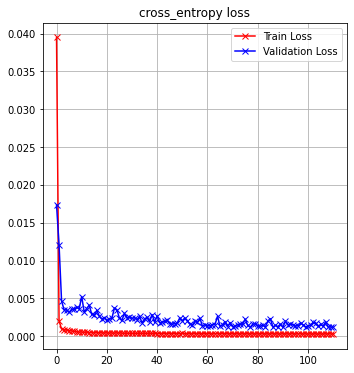

In [ ]:
#print(history.history.keys())
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    

plot_loss_accuracy(history)
#print(history.history.keys())

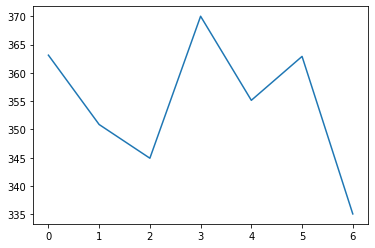

In [ ]:
plt.plot(prediction[-1])
plt.show()

In [ ]:
dates = []
i = 0
while i <7:
  dates.append((datetime.now() + timedelta(days=i))) #.strftime('%Y-%m-%d')
  i += 1

In [ ]:
preds = np.array(prediction).reshape(-1,7)
preds = pd.DataFrame(data = preds[-1], index = dates)
gs_adj = pd.DataFrame(data = GS["Adj Close"]['2021-04-01':], index = GS.index[-len(x_test):])

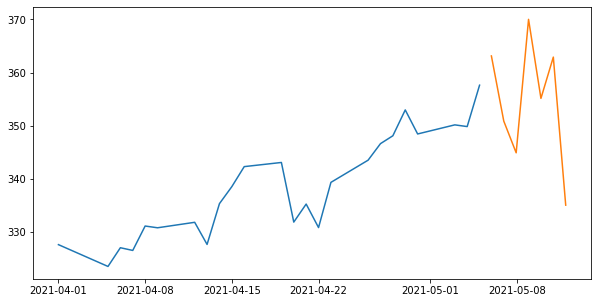

In [ ]:
merge=pd.concat([gs_adj , preds], axis = 1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(merge["Adj Close"], label = "Adj Close")
ax.plot(merge[0], label = "Future Trend")
plt.show()

In [ ]:
train_predict = model.predict(x_train)
valid_predict = model.predict(x_valid)
test_predict = model.predict(x_test)

In [ ]:
train_predict1 = pd.DataFrame(scaler.inverse_transform(train_predict).squeeze(), index = y_serie[:'2020-06-30'].index)
valid_predict1 = pd.DataFrame(scaler.inverse_transform(valid_predict).squeeze(), index = y_serie['2020-07-01':'2021-03-31'].index)
test_predict1 = pd.DataFrame(scaler.inverse_transform(test_predict).squeeze(), index = GS_scaled['2021-04-01':].index)

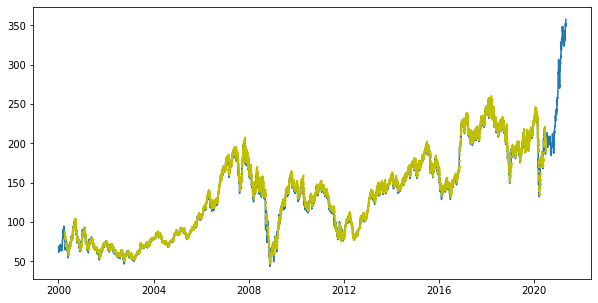

In [ ]:
plt.close()
#Plotting the training prediction results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
index1 = all_data.index[window_size:]
plt.plot(all_data['Adj Close'])
i = 0
for date in train_predict1.index:
  t = train_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'y')
  i += 1

plt.show()

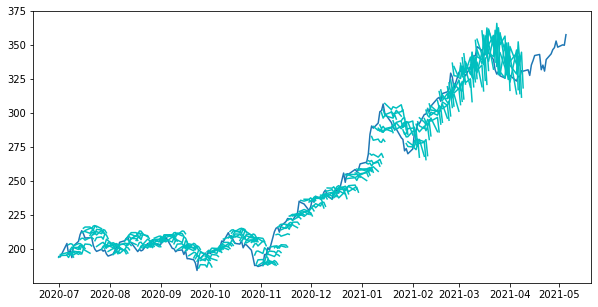

In [ ]:
plt.close()
#Plotting the validation prediction results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(all_data['Adj Close']['2020-07-01':])
for date in valid_predict1.index:
  t = valid_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'c')
  i += 1

plt.show()

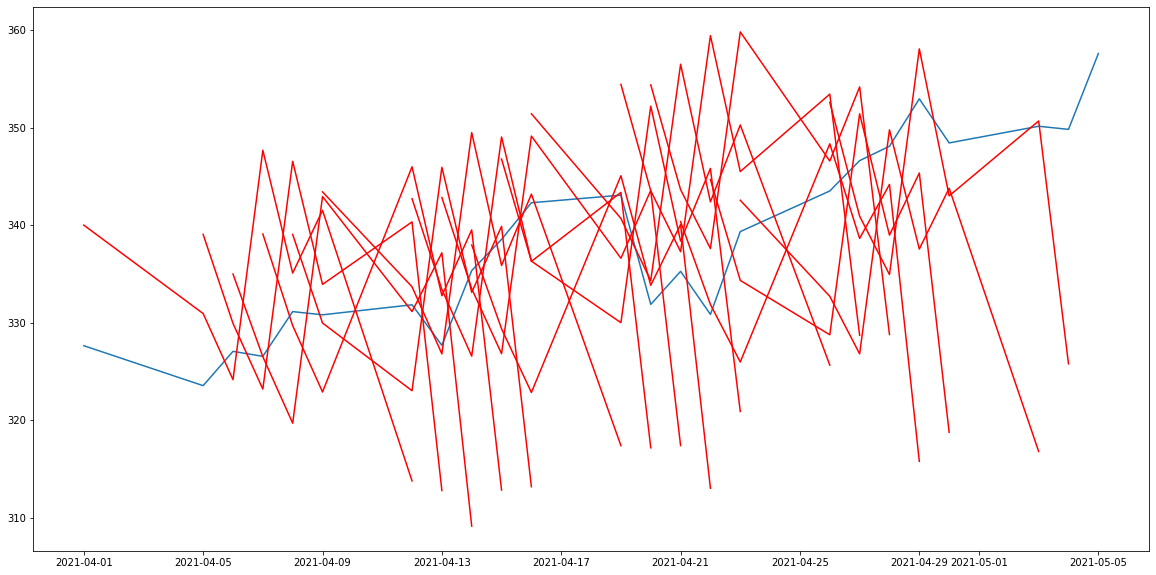

In [ ]:
plt.close()
#Plotting the validation prediction results

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(all_data['Adj Close']['2021-04-01':])
for date in test_predict1.index[:-7]:
  t = test_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'r')
  i += 1

plt.show()

In [ ]:
y_train_rescaled = scaler.inverse_transform(y_train.squeeze())

train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, train_predict1))# Train Standard Deviation

y_valid_rescaled = scaler.inverse_transform(y_valid.squeeze())
valid_rmse = np.sqrt(mean_squared_error(y_valid_rescaled,valid_predict1))# Valid Standard Deviation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


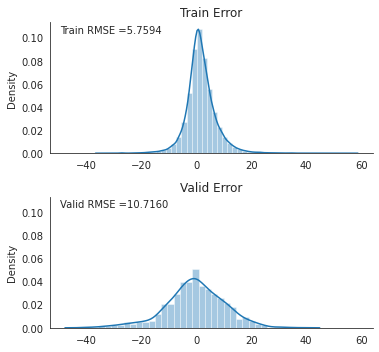

In [ ]:
fig=plt.figure(figsize=(10,5))


with sns.axes_style("white"):
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict1.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(valid_predict1.squeeze()-y_valid_rescaled, ax=ax4)
    ax4.set_title('Valid Error')
    ax4.text(x=.03, y=.92, s=f'Valid RMSE ={valid_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()